# Dam Break Simulation Analysis
## 1. Physical Context and Methodology
This notebook analyzes the collapse of a water column (Dam Break) using the **Smoothed Particle Hydrodynamics (SPH)** method. The objective is to validate the numerical model by comparing the results with experimental data from **Koshizuka & Oka (1996)** and previous simulations from **Crespo et al. (2007)**.

The main physical parameters monitored are:
* **Front position ($x_{max}$)**: The maximum horizontal extent of the fluid.
* **Column height ($y_{max}$)**: The residual height of the fluid at the left wall.

The results are non-dimensionalized using the initial height $H$ and gravity $g$.

In [1]:
import os
from pathlib import Path
from typing import Tuple, List, Dict, Any

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from h5py import File
from natsort import natsorted
from functools import lru_cache

# Specific imports for the simulation
from pysph.solver.utils import load

# --- Configuration for the "scientific" style ---
plt.style.use("science")
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman'],
    'text.usetex': True,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'legend.fontsize': 10,
    'figure.figsize': (8, 6),
    'lines.linewidth': 1.5,
    'savefig.dpi': 300
})

In [2]:
# --- Configuring data des données ---
# We use Path for a clean management of paths on Windows/Linux

BASE_DIR = Path("../") 
OUTPUT_PREFIX = 'Water_tf_0_lx_1_ly_2_rho1000.0'
DATA_DIR = BASE_DIR / "outputs" / f"{OUTPUT_PREFIX}_output"

# Checking if the file exists to avoid future errors
if not DATA_DIR.exists():
    print(f"⚠️ Warning : File {DATA_DIR} was not found.")

In [3]:
# --- SECTION 2: DATA ACQUISITION ---

@lru_cache(maxsize=1)
def get_hdf5_files(data_directory: Path) -> List[str]:
    """
    Scans the output directory and returns a sorted list of HDF5 files.
    Using natsorted to ensure 'file_10.hdf5' comes after 'file_2.hdf5'.
    """
    if not data_directory.exists():
        raise FileNotFoundError(f"Directory {data_directory} does not exist.")
    
    files = list(data_directory.glob("*.hdf5"))
    return natsorted([str(f) for f in files])

def load_snapshot(file_path: str) -> Tuple[float, Dict[str, np.ndarray]]:
    """
    Loads a specific SPH solver output file.
    Returns the simulation time and the particle arrays.
    """
    data = load(file_path)
    time = data['solver_data']['t']
    arrays = data['arrays']
    return time, arrays

# Initialize file list
try:
    all_files = get_hdf5_files(DATA_DIR)
    print(f"Successfully indexed {len(all_files)} files in {DATA_DIR.name}")
except Exception as e:
    print(f"Error: {e}")

Successfully indexed 2001 files in Water_tf_0_lx_1_ly_2_rho1000.0_output


## 2. Data Processing
In this section, we iterate through the simulation snapshots to extract physical quantities over time. 
For each frame, we compute:
* The **Position of the front** ($x_{max}$): defined as the maximum x-coordinate of the fluid particles.
* The **Column height** ($h$): defined as the maximum y-coordinate.
* The **Velocity Magnitude** ($V_{mag}$): calculated as $\sqrt{u^2 + v^2}$.

The data is stored in a structured format for further plotting and comparison with benchmark data.

In [4]:
# Lists to store temporal evolution
times = []
x_max_values = []
y_max_at_wall = []

# Define the sampling window for column height (around x=0.5)
# This avoids particles stuck on the wall outside the main column
X_WINDOW_MIN = 0.48
X_WINDOW_MAX = 0.52

print(f"Processing {len(all_files)} files...")

for filepath in all_files:
    t, arrays = load_snapshot(filepath)
    
    # Access fluid particles
    fluid = arrays['fluid']
    x = fluid.x
    y = fluid.y
    
    # 1. Front position: absolute maximum x of the fluid
    x_max_values.append(np.max(x))
    
    # 2. Column height: maximum y within the specified vertical window
    # We use a boolean mask to filter particles spatially
    mask_window = (x >= X_WINDOW_MIN) & (x <= X_WINDOW_MAX)
    
    if np.any(mask_window):
        y_max_at_wall.append(np.max(y[mask_window]))
    else:
        # Fallback if no particles are in the window (safety check)
        y_max_at_wall.append(0.0)
        
    times.append(t)

# Conversion to numpy arrays for plotting
times = np.array(times)
x_max = np.array(x_max_values)
y_max = np.array(y_max_at_wall)

print(f"Extraction complete: {len(times)} snapshots processed.")

Processing 2001 files...
Extraction complete: 2001 snapshots processed.


## 3. Validation and Benchmarking
In this section, we load experimental and numerical data from the literature to validate our SPH model.
* **Koshizuka & Oka (1996)**: Experimental data obtained from a water column collapse.
* **Crespo et al. (2007)**: Numerical data from an earlier SPH study.

We also define the physical constants used for non-dimensionalization to ensure consistent comparisons.

In [5]:
# --- SECTION 3: EXTERNAL DATA LOADING ---

# Physical constants for scaling
GRAVITY = 9.81  # m/s^2
H_0 = 2.0       # Initial height (adjust based on your lx/ly setup)

# Loading Benchmark Dataframes
try:
    # Koshizuka & Oka (1996) - Experimental
    df_koshizuka_x = pd.read_csv('koshizuka_oka_1996_x.csv')
    df_koshizuka_h = pd.read_csv('koshizuka_oka_1996_h.csv')
    
    # Crespo et al. (2007) - Numerical SPH
    df_crespo_x = pd.read_csv('crespo_2007_x.csv')
    df_crespo_h = pd.read_csv('crespo_2007_h.csv')
    
    print("Successfully loaded all benchmark CSV files.")
except FileNotFoundError as e:
    print(f"Error: Could not find benchmark files. {e}")

Successfully loaded all benchmark CSV files.


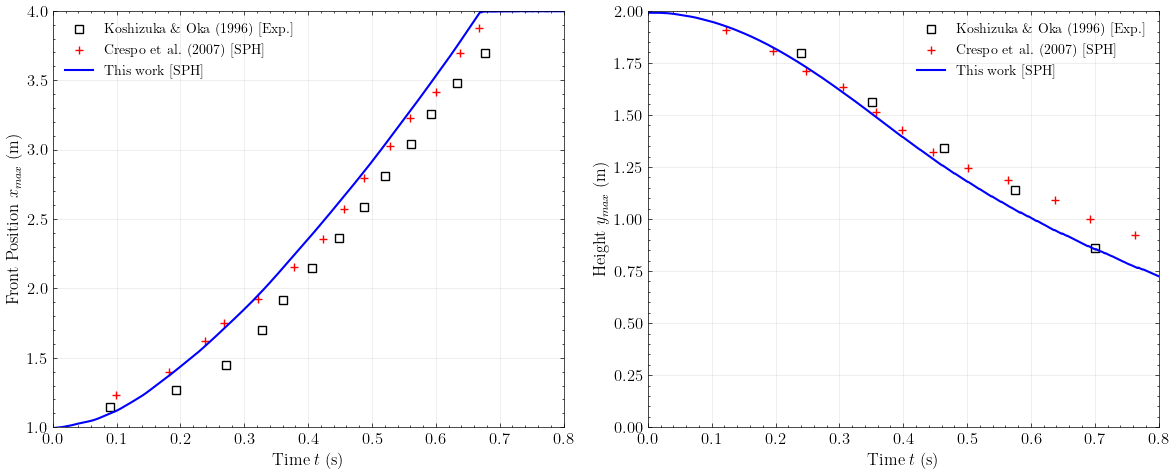

In [6]:
# --- SECTION 4: VISUALIZATION ---

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Scaling factor in these papers: sqrt(2g/L) 
# In this work: np.sqrt(2 * GRAVITY/1)
time_scale = np.sqrt(2 * GRAVITY)

# Plot 1: Front Position (Extent)
ax1.plot(df_koshizuka_x['x'] / time_scale, df_koshizuka_x['y'], 
         'ks', mfc='none', label='Koshizuka \& Oka (1996) [Exp.]')
ax1.plot(df_crespo_x['x'], df_crespo_x['y'], 
         'r+', label='Crespo et al. (2007) [SPH]')
ax1.plot(times, x_max, 'b-', label='This work [SPH]')

ax1.set_xlabel(r'Time $t$ (s)')
ax1.set_ylabel(r'Front Position $x_{max}$ (m)')
ax1.set_xlim(0, 0.8)
ax1.set_ylim(1, 4)
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Column Height
# Adjusting based on scaling factor
ax2.plot(df_koshizuka_h['x'] * np.sqrt(1/(2 * GRAVITY)), df_koshizuka_h['y'] * 2, 
         'ks', mfc='none', label='Koshizuka \& Oka (1996) [Exp.]')
ax2.plot(df_crespo_h['x'], df_crespo_h['y'], 
         'r+', label='Crespo et al. (2007) [SPH]')
ax2.plot(times, y_max, 'b-', label='This work [SPH]')

ax2.set_xlabel(r'Time $t$ (s)')
ax2.set_ylabel(r'Height $y_{max}$ (m)')
ax2.set_xlim(0, 0.8)
ax2.set_ylim(0, 2)
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Quantitative Validation: RMSE Analysis
To objectively assess the accuracy of the SPH simulation, we calculate the **Root Mean Square Error (RMSE)** between our numerical results and the experimental benchmarks from Koshizuka & Oka (1996).

Since the simulation snapshots and experimental data points are not sampled at the same time intervals, we use **linear interpolation** to map the simulation results onto the experimental time points.

The RMSE is defined as:
$$RMSE = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (y_{i, \text{sim}} - y_{i, \text{exp}})^2}$$

In [7]:
from scipy.interpolate import interp1d

TIME_TO_PHYS = np.sqrt(2*GRAVITY/1)

# --- SECTION 5: ERROR QUANTIFICATION ---

def calculate_rmse(t_exp, val_exp, t_sim, val_sim):
    """
    Interpolates simulation data to experimental time points 
    and calculates the RMSE.
    """
    # Create interpolation function for simulation data
    f_interp = interp1d(t_sim, val_sim, kind='linear', fill_value="extrapolate")
    
    # Interpolate simulation values at experimental times
    val_sim_at_exp = f_interp(t_exp)
    
    # Calculate RMSE
    mse = np.mean((val_sim_at_exp - val_exp)**2)
    return np.sqrt(mse)

# 1. Prepare experimental data in physical units
t_exp_x_phys = df_koshizuka_x['x'] / TIME_TO_PHYS
x_exp_phys = df_koshizuka_x['y'] * 1

t_exp_h_phys = df_koshizuka_h['x'] / TIME_TO_PHYS
h_exp_phys = df_koshizuka_h['y'] * H_0

# 2. Compute RMSE
rmse_x = calculate_rmse(t_exp_x_phys, x_exp_phys, times, x_max)
rmse_h = calculate_rmse(t_exp_h_phys, h_exp_phys, times, y_max)

# 3. Display results
print("-" * 30)
print(f"{'Metric':<20} | {'RMSE [m]':<10}")
print("-" * 30)
print(f"{'Front Position (x)':<20} | {rmse_x:.4f}")
print(f"{'Residual Height (y)':<20} | {rmse_h:.4f}")
print("-" * 30)

------------------------------
Metric               | RMSE [m]  
------------------------------
Front Position (x)   | 0.2371
Residual Height (y)  | 0.0574
------------------------------
